### Theoretical methods of deep learning: Homework assignment 4
Submit solution by uploading to canvas, **by Sunday, December 4th, 23:59**

**Problem 1.** Consider the hierarchical broadcasting with the 2-state spin and the transition matrix 

$$M=(P(\sigma_1|\sigma_0))=\begin{pmatrix}
1-\epsilon & 0 \\
\epsilon & 1 \end{pmatrix}$$

(i.e., the first state changes with probability $\epsilon$ to second state, while the second state never changes).

1. How does the maximum likelihood reconstruction work for this model? (Give a simple explicit description.)
2. Assume that the branching number is $b$. Find theoretically for which pairs $(b,\epsilon)$ the reconstruction is solvable/unsolvable (give proofs).
3. For branching number $b=2$, find explicitely the survival probability of the first state (i.e., $P(\bigcap_{n\in\mathbb N}(\exists k:\pmb\sigma_n(k)=1)|\sigma_0=1)$, where $\pmb\sigma_n(k)$ denotes the $k$'th spin in the $n$'th layer), as a function of $\epsilon$.
3. Confirm the obtained theoretical phase diagram numerically.

1. $\sigma_0$ - root state, $(1, 2)$ - first and second state respectively. <br> If $\sigma_0 = 2$ then $\forall n, k \rightarrow \pmb \sigma_n(k) = 2$. So if the last layer $\pmb \sigma_n$ contains 1-state, ML will predict $\sigma_0^\text{ML} = 1$ (since $P(\pmb \sigma_n: \{ \exists k: \pmb \sigma_n(k) = 1\}|\sigma_0 = 2) = 0$). <br>
Now let's consider $\pmb \sigma_n : \forall k \rightarrow \pmb\sigma_n(k) = 2$.
$$P(\pmb \sigma_n|\sigma_0 = 2) = 1$$
$$P(\pmb \sigma_n|\sigma_0 = 1) = (1 - (1 - \epsilon)^n)^{b^n} < 1$$
So in this case ML will predict  $\sigma_0^\text{ML} = 2$.
2. 
$$P^s_n(\pmb \sigma_n) = P(\pmb \sigma_n | \sigma_0 = s)$$
$P^{s=2}_n(\pmb \sigma_n) \neq 0$ only if $\forall k \rightarrow \pmb \sigma_n(k) = 2$.
$$P^{s=1}_n(\pmb \sigma_n) = ((1 - \epsilon)^{n})^k(1 - (1 - \epsilon)^{n})^{b^n - k} \quad \text{where k - number of 1 states on the last level}$$
$$\| P^{s=1}_{n} - P^{s=2}_{n} \|_1 = (1 - (1 - (1 - \epsilon)^n)^{b^n}) + \sum_{k = 1}^{b^n} C_{b^n}^k ((1 - \epsilon)^{n})^k(1 - (1 - \epsilon)^{n})^{b^n - k} = (1 - (1 - (1 - \epsilon)^n)^{b^n}) + 1 - (1 - (1 - \epsilon)^{n})^{b^n} = 2(1 - (1- (1 - \epsilon)^n)^{b^n}$$
Let's explore the limit of $f(n) = (1- (1 - \epsilon)^n)^{b^n}$ as $n\rightarrow \infty$
$$ \ln f(n) = b^n \ln(1 - (1 - \epsilon)^n) \overset{|1 - \epsilon| \leq 1}{\rightarrow} -b^n(1 - \epsilon)^n = -(b(1 - \epsilon))^n$$
If $b(1 - \epsilon) > 1 \Rightarrow \epsilon < 1 - \frac{1}{b} \rightarrow f(n) \overset{n \rightarrow \infty}{\rightarrow} 0.$ <br>\
If $b(1 - \epsilon) < 1 \Rightarrow \epsilon > 1 - \frac{1}{b} \rightarrow f(n) \overset{n \rightarrow \infty}{\rightarrow}$ 1.
3.
$$\text{survival rate} = 1 - \text{death rate}$$
$$\text{death rate} = P_\text{death}(n) = P(\pmb\sigma_n:\forall k \rightarrow \pmb\sigma_n(k) = 2|\sigma_0=1)$$
Let's also denote $P_k(n) = P(\pmb\sigma_n(k) = 2|\sigma_0=1)$ - probability that one chosen spin on the n-th level has state $2$. Due to the symmetry $P_k(n)$ does not depend on  $k$.
$$P_\text{death}(n) = \prod_{k_i \in \pmb \sigma_n} P_k(n) = (P_0(n))^{2^n}$$
Consider some spin on layer $n + 1$: <br>
Probability that it is in the state 2 is $1 - (1 - \epsilon)^n$ (second term represents situation when all of its ancestors stayed in state 1).
$$ P_0(n) = 1 - (1 - \epsilon)^n \Rightarrow P_\text{death}(n) = (1 - (1 - \epsilon)^n)^{2^n}$$
$$\text{survival rate} = 1 - (1 - (1 - \epsilon)^n)^{2^n}$$

In [66]:
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline


def makeRandFlips(spinA,  # input spins at a certain hierarchy level, as an array 
                  b,      # branching number
                  eps     # spin flip probability
                  ):
    shape1 = [b] + list(spinA.shape)
    spinA1 = np.empty(shape1, 'int')
    for a in range(b):
        flipA = np.random.rand(*list(spinA.shape)) < eps
        #print('Spin', spinA, '\n', 'flip', flipA)
        #print('sum', spinA + flipA)
        spinA1[a] = np.clip(spinA + flipA, 1, 2)
        #print('res', spinA1)
    return spinA1    # spins at the next level


def runRandFlow(depth, 
                b,
                eps,
                root=1
               ): # run a full random hierarchical flow of spin flips
    spinA = np.array([root], 'int')
    spinAL = [spinA]

    for level in range(depth):
        spinAL.append(makeRandFlips(spinAL[-1], b, eps))
    return spinAL # the full flow as a list of arrays


def spinAL2tree(spinAL,
                plot=True,
                savefig=False
               ): # convert spin array list into a tree
    tree = nx.DiGraph()
    for level in range(len(spinAL)):
        for index, value in np.ndenumerate(spinAL[level]):
            node = tree.add_node(index)
            tree.nodes[index]['v'] = value
            if level > 0:
                predecessor = tuple(list(index)[1:])
                tree.add_edge(predecessor, index)
    
    # assign reasonable positions and colors for visualization
    pos = nx.spring_layout(tree)
    for level in range(len(spinAL)):  
        for index, value in np.ndenumerate(spinAL[level]):
            pos[index] = (np.sum([3.1**(l-level)*(index[l]-(spinAL[level].shape[l]-1.)/2)/(spinAL[level].shape[l]-1.+1e-8) 
                                  for l in range(level+1)]),
                         -level)  
    if plot:
        nx.draw(tree, pos, node_color=['b' if tree.nodes[node]['v']==1 else 'r' for node in tree.nodes], node_size=100)
        if savefig:
            plt.savefig('tree.pdf')
    return tree


def reconstruct(spinA, # final layer 
                method,
                eps=0.5 # needed for Max Likelihood reconstruction
               ):
    spinA = spinA - 1.5
    if method == 'random':
        root = np.random.randint(2)-1
        
    elif method == 'globalMajority':
        root = 1 if np.sum(spinA) > 0 else -1
    
    elif method == 'localMajority':
        for layer in range(len(spinA.shape)-1):
            spinA = 2*(spinA.sum(axis=0) > 0)-1
        root = int(spinA)
        
    elif method == 'maxLikelihood':
        
        spinApos = spinA > 0
        spinAneg = spinA < 0      
        for layer in range(len(spinA.shape)-1):
            spinApos, spinAneg = ((spinApos).prod(axis=0), 
                                   (spinAneg*(1-eps)+spinApos*eps).prod(axis=0) )
            
            # normalize to avoid convergence to 0
            m = spinApos+spinAneg
            spinApos, spinAneg = spinApos/m, spinAneg/m
            
        root = int(2*(spinApos > spinAneg)-1)
        
    return int(root / 2 + 1.5)

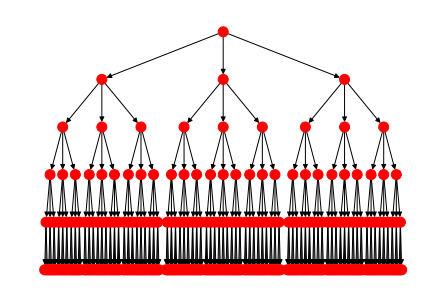

In [55]:
spinAL = runRandFlow(depth=5, 
                     b=3,
                     eps=0.2,
                     root=2)

tree = spinAL2tree(spinAL)

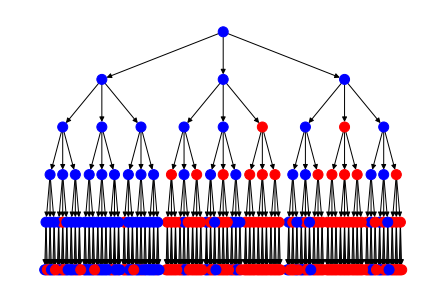

In [46]:
spinAL = runRandFlow(depth=5, 
                     b=3,
                     eps=0.2,
                     root=1)

tree = spinAL2tree(spinAL)

True root: 1
random 1
globalMajority 2
localMajority 1
maxLikelihood 1


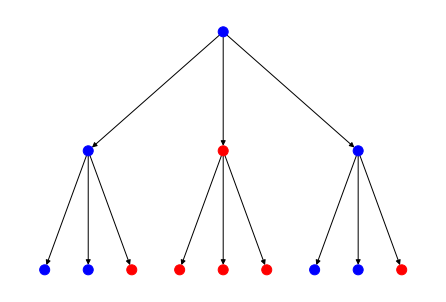

In [60]:
def testReconstruct():
    root = np.random.randint(2) + 1
    print ('True root:', root)
    
    depth = 2
    b = 3
    eps = 0.2

    spinAL = runRandFlow(depth=depth, 
                 b=b,
                 eps=eps,
                 root=root)

    tree = spinAL2tree(spinAL)

    methodL = ['random', 'globalMajority', 'localMajority', 'maxLikelihood']
    for method in methodL:
        root = reconstruct(spinAL[-1], method, eps)
        print (method, root)
        
testReconstruct()

In [69]:
def getShareCorrect(Nruns,
                   depth,
                   b,
                   eps,
                   methodL
                  ):
    Ncorrect = {}
    for method in methodL:
        Ncorrect[method] = 0 

    for _ in range(Nruns):
        root = np.random.randint(2)+1
        spinAL = runRandFlow(depth=depth, 
                             b=b,
                             eps=eps,
                             root=root)
        for method in methodL:
            rootPred = reconstruct(spinAL[-1], method, eps)
            Ncorrect[method] += rootPred == root
    
    shareCorrect = dict([(method, float(Ncorrect[method])/Nruns) for method in methodL])
    return shareCorrect

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

critical epsilon: 0.5


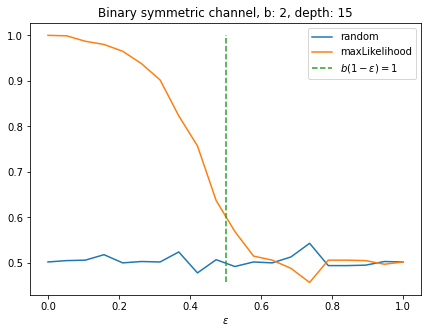

In [72]:
from tqdm.notebook import tqdm


Nruns = 1000
depth = 15
b = 2
epsL = np.linspace(0, 1, 20)
shareCorrect = {}
methodL = ['random','maxLikelihood']
for method in methodL:
    shareCorrect[method] = []
for eps in tqdm(epsL):
    res = getShareCorrect(Nruns, depth, b, eps, methodL)
    for method in tqdm(methodL):
        shareCorrect[method].append(res[method])

plt.figure(figsize=(7,5))
        
for method in methodL:
    plt.plot(epsL, shareCorrect[method], label=method)
    
yrange = [np.min(shareCorrect['maxLikelihood']), np.max(shareCorrect['maxLikelihood'])]

eps_crit_SK = 1 - 1/b 
print ('critical epsilon:', eps_crit_SK)
plt.plot([eps_crit_SK, eps_crit_SK], yrange, '--', label='$b(1-\epsilon)=1$')


plt.legend()
plt.xlabel('Success probability')
plt.xlabel('$\epsilon$')
plt.title('Binary symmetric channel, b: %d, depth: %d' %(b, depth))
plt.savefig('reconstruction_comparison.pdf')
plt.show()

**Problem 2.** Suppose we are fitting a function $y=f(\mathbf x), f:\mathbb R^{d}\to\mathbb R,$ by a neural network $\widetilde f(\mathbf x, \mathbf W)$, where $\mathbf W$ are all the weights of the network. Consider the standard quadratic loss function $L(\mathbf W)=\tfrac{1}{2N}\sum_{n=1}^N(y_n-\widetilde f(\mathbf x_n, \mathbf W))^2$, where $\{(\mathbf x_n,y_n)\}$ is a training set. Suppose that the network $\widetilde f$ has $U$ neurons and $V$ connections. As usual, each hidden neuron computes an expression of the form $\sigma(\sum_{k}w_kz_k+h)$, where $z_k$ denotes neuron inputs, and $\sigma$ is an activation function. 

Count the total number of elementary operations required to compute the gradient $\nabla_{\mathbf W}L(\mathbf W)$ by backpropagation. (Assume that an elementary operation is an arithmetic operation or an evaluation of $\sigma(x)$ or $\sigma'(x)$.)

$$\nabla_{\mathbf W}L(\mathbf W) = \frac{1}{2}\sum_{n=1}^N(\widetilde f(\mathbf x_n, \mathbf W) - y_n) \nabla_{\mathbf W}\widetilde f(\mathbf x_n, \mathbf W)$$
$w^{(k)}_{lt}$ - weight between $l$-th and $t$-th neuron on layers $k$ and $k + 1$, $z^{(k)}_l$ - output of $l$-th neuron on $k$-th layer. <br>
First of all we need to compute the forward pass. Consider some neuron i (denote number of connections coming to it from previous layer as $c_i$), if we want to calculate its output we would need to make $c_i$ multiplications, $c_i$ additions ($c_i - 1$ variables + bias) and 1 activation, $2c_i + 1$ operations in total. Summing over all neurons we get $2 \cdot \{ \text{total # connections} \} + \{ \text{total # of neurons}\}$ for forward pass. <br>
We should calculate derrivatives up to the first layer, and since we are using backpropogation all other derrivatives will be computed along the way.
$$\widetilde f(\mathbf x_n, \mathbf W) = \sigma \left( \sum_k w^{(L)}_k z^{(L)}_k + h_L \right)$$
$$\frac{\partial \widetilde f(\mathbf x_n, \mathbf W)}{\partial w^{(0)}_{lt}} = \sigma' \left( \sum_k w^{(L)}_k z^{(L)}_k + h_L \right) \sum_k w^{(L)}_k \frac{\partial z^{(L)}_k}{\partial w^{(0)}_{lt}}$$
$$\frac{\partial z^{(L)}_r}{\partial w^{(0)}_{lt}} = \sigma' \left( \sum_k w^{(L - 1)}_{kr} z^{(L - 1)}_k + h_{L - 1} \right) \sum_k w^{(L - 1)}_{kr} \frac{\partial z^{(L)}_k}{\partial w^{(0)}_{lt}}$$
$$ \ldots $$
$$\frac{\partial z^{(2)}_r}{\partial w^{(0)}_{lt}} = \sigma' \left( \sum_k w^{(1)}_{kr} z^{(1)}_k + h_{1} \right) w^{(1)}_{tr} \frac{\partial z^{(1)}_t}{\partial w^{(0)}_{lt}}$$
$$\frac{\partial z^{(1)}_t}{\partial w^{(0)}_{lt}} = \sigma' \left( \sum_k w^{(0)}_{kr} x_k + h_{0} \right) x_l$$
For simplicity we can consider all weights to be nonzero. Also remember that all neurons' outputs are computed during the forward pass. Let's move from the bottom to the top of this chain and count operations. $\frac{\partial z^{(1)}_t}{\partial w^{(0)}_{lt}}$ requires 2 operations, $\frac{\partial z^{(2)}_r}{\partial w^{(0)}_{lt}}$ will require 3 more operations but now we should calculate it for all $r$ on the layer $(2)$ (3 $\cdot$ #number of neurons on (2)). For the $\frac{\partial z^{(3)}_r}{\partial w^{(0)}_{lt}}$ we would need 1 operation for $\sigma'$, $2 \cdot$ #{number of connections between $z^{(3)}_r$ and layer $(2)$} - 1 for sums and multiplication of weights and derrivatives. Once again we should compute it for all neurons on $(3)$, so in total we have $2 \cdot$ #{number of connections between layer $3$ and layer $2$}. From now on the logic is the same as with layers $(2, 3)$, on every step we would need $2 \cdot$ #{number of connections between layer $X$ and layer $X + 1$} operations. <br> For all derrivative we would need $2 \cdot \{\text{total # of connections}\}$. <br>
$\nabla_{\mathbf W}\widetilde f(\mathbf x_n, \mathbf W)$ with forward and backward passes requires $4V + U$ operations. (with fixed $\mathbf x_n$). $\nabla_{\mathbf W}L(\mathbf W)$ will require $(4V + U + 2) \cdot N + 1$ operations.
